In [2]:
# !kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes         61           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        141           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge        187           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       1573           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      49920            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.metrics import roc_auc_score
# import riiideducation
# from tqdm import tqdm

In [2]:
# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

[Riiid Answer Correctness Prediction 링크](https://www.kaggle.com/c/riiid-test-answer-prediction)

In [4]:
'''
question == 문제
tag = 해설지(코드)
tags = 비슷한 것 끼리 묶은 것들

train.csv

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. 
For example, a user might see three questions in a row before seeing the explanations for any of them. 
Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 
in the previous question bundle, ignoring any lectures in between. 
Is null for a user's first question bundle or lecture. 
Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) 
after answering the previous question bundle, ignoring any lectures in between. 
The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. 
Typically the first several questions a user sees were part of an onboarding diagnostic test 
where they did not get any feedback.



questions.csv: metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.



lectures.csv: metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture



example_test_rows.csv Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.
'''

"\nquestion == 문제\ntag = 해설지(코드)\ntags = 비슷한 것 끼리 묶은 것들\n\ntrain.csv\n\nrow_id: (int64) ID code for the row.\n\ntimestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.\n\nuser_id: (int32) ID code for the user.\n\ncontent_id: (int16) ID code for the user interaction\n\ncontent_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.\n\ntask_container_id: (int16) Id code for the batch of questions or lectures. \nFor example, a user might see three questions in a row before seeing the explanations for any of them. \nThose three would all share a task_container_id.\n\nuser_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.\n\nanswered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.\n\nprior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 

### 데이터 불러오기

In [5]:
# 현석

train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**7)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [6]:
# 소비

# train = pd.read_csv('train.csv', nrows=10**7)
# test = pd.read_csv("example_test.csv")
# lectures = pd.read_csv("lectures.csv")
# questions = pd.read_csv("questions.csv")

In [7]:
# 연규 

# train = pd.read_csv('D:/Project_dataset/Pr_riid//train.csv', nrows=10**4)
# test = pd.read_csv("D:/Project_dataset/Pr_riid/example_test.csv")
# lectures = pd.read_csv("D:/Project_dataset/Pr_riid/lectures.csv")
# questions = pd.read_csv("D:/Project_dataset/Pr_riid/questions.csv")

### train.csv

In [8]:
train

row_id  timestamp    user_id  content_id  content_type_id  \
0              0          0        115        5692                0   
1              1      56943        115        5716                0   
2              2     118363        115         128                0   
3              3     131167        115        7860                0   
4              4     137965        115        7922                0   
...          ...        ...        ...         ...              ...   
9999995  9999995  646228695  216747867        8805                0   
9999996  9999996  646321314  216747867        5708                0   
9999997  9999997  646393443  216747867        5434                0   
9999998  9999998  646445632  216747867        6429                0   
9999999  9999999  690225760  216747867        9010                0   

         task_container_id  user_answer  answered_correctly  \
0                        1            3                   1   
1                        2            2                   1   
2                        0            0                   1   
3                        3            0                   1   
4                        4            1                   1   
...                    ...          ...                 ...   
9999995                410            1                   1   
9999996                411            0                   0   
9999997                412            0                   0   
9999998                413            3                   1   
9999999                414            2                   1   

         prior_question_elapsed_time prior_question_had_explanation  
0                                NaN                            NaN  
1                            37000.0                          False  
2                            55000.0                          False  
3                            19000.0                          False  
4                            11000.0                          False  
...                              ...                            ...  
9999995                      23000.0                           True  
9999996                      13000.0                           True  
9999997                      66000.0                           True  
9999998                      37000.0                           True  
9999999                      16000.0                           True  

[10000000 rows x 10 columns]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 762.9+ MB


In [10]:
train.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

In [11]:
# timestamp : 수강권을 끊은 유저가 강의를 본 시간이나 문제를 푼 총 시간
# train[train.user_id == 91216][:30]

In [12]:
train.user_id.unique()

array([      115,       124,      2746, ..., 216743480, 216747710,
       216747867], dtype=int64)

In [13]:
train.user_id.nunique()

39491

In [14]:
# content_id = lecture_id + question_id
train.content_id.unique()

array([5692, 5716,  128, ..., 7848, 7850, 7849], dtype=int64)

In [15]:
# 21명이 총 6576개의 lecture랑 question를 보았다.
train.content_id.nunique()

13749

In [16]:
# 0이면 바로 문제푼거고, 1이면 강의를 본거고
train.content_type_id.value_counts()

0    9804604
1     195396
Name: content_type_id, dtype: int64

In [17]:
'''
task_container_id 설명

task_container_id: (int16) Id code for the batch of questions or lectures. => id code다 무엇을 위한? 배치인데 문제들이나 강의들에 대한
For example, a user might see three questions in a row before seeing the explanations for any of them. => 예를 들어 한 유저가 연속적인 3 문제를 볼거야 / 그거이 어떤 것이든 문제의 해설지를 보기 전에
Those three would all share a task_container_id. => 이러한 3개 문제들은 하나의 task_container_id를 공유해

task_container_id는 문제 타입 유형의 갯수 (누적)


문제가 나왔다.

sum=0
if 강의 봤어
sum+=1
task_cont.append[sum]
elif 강의 안 보고 문제만 풀었어 
sum+=1


틀렸어. 그 문제 유형이 사역동사. 묻는 문제
계속 틀려. => 산타토익 추천 => 사역동사 관련 강의 볼래? => 1 (강의 봤어) => ok => 사역동사 관련 강의 (7900) => 그 문제 유형을 다시 푼다. => 얘는 강의를 봤네? 산타토익은 본거 체크 0->1(task_container_id)
계속 틀려 => 산토팅ㄱ 추천 => 안보고 계속 풀어 => 0 (강의 안봤어)

 계속 틀려 => 산타토익 추천 => be동사 관련 강의(cotnent_id) 볼래? 아니 안 볼래 = > 0(content_type_id) => 강의 안보고도 문제 푸는 거 => 이 문제 유형을 풀었네 1->2 (task_container_id)


ex)
사역동사 : 7900
be동사 : 7876
5형식 동사 : 175 
'''

'\ntask_container_id 설명\n\ntask_container_id: (int16) Id code for the batch of questions or lectures. => id code다 무엇을 위한? 배치인데 문제들이나 강의들에 대한\nFor example, a user might see three questions in a row before seeing the explanations for any of them. => 예를 들어 한 유저가 연속적인 3 문제를 볼거야 / 그거이 어떤 것이든 문제의 해설지를 보기 전에\nThose three would all share a task_container_id. => 이러한 3개 문제들은 하나의 task_container_id를 공유해\n\ntask_container_id는 문제 타입 유형의 갯수 (누적)\n\n\n문제가 나왔다.\n\nsum=0\nif 강의 봤어\nsum+=1\ntask_cont.append[sum]\nelif 강의 안 보고 문제만 풀었어 \nsum+=1\n\n\n틀렸어. 그 문제 유형이 사역동사. 묻는 문제\n계속 틀려. => 산타토익 추천 => 사역동사 관련 강의 볼래? => 1 (강의 봤어) => ok => 사역동사 관련 강의 (7900) => 그 문제 유형을 다시 푼다. => 얘는 강의를 봤네? 산타토익은 본거 체크 0->1(task_container_id)\n계속 틀려 => 산토팅ㄱ 추천 => 안보고 계속 풀어 => 0 (강의 안봤어)\n\n 계속 틀려 => 산타토익 추천 => be동사 관련 강의(cotnent_id) 볼래? 아니 안 볼래 = > 0(content_type_id) => 강의 안보고도 문제 푸는 거 => 이 문제 유형을 풀었네 1->2 (task_container_id)\n\n\nex)\n사역동사 : 7900\nbe동사 : 7876\n5형식 동사 : 175 \n'

In [18]:
train[train.user_id == 124]

row_id  timestamp  user_id  content_id  content_type_id  \
46      46          0      124        7900                0   
47      47      32683      124        7876                0   
48      48      62000      124         175                0   
49      49      83632      124        1278                0   
50      50     189483      124        2064                0   
51      51     189483      124        2063                0   
52      52     189483      124        2065                0   
53      53     258793      124        3364                0   
54      54     258793      124        3365                0   
55      55     258793      124        3363                0   
56      56     330528      124        2948                0   
57      57     330528      124        2947                0   
58      58     330528      124        2946                0   
59      59     382790      124        2595                0   
60      60     382790      124        2593                0   
61      61     382790      124        2594                0   
62      62     419266      124        4492                0   
63      63     445527      124        4120                0   
64      64     475421      124        4696                0   
65      65     492328      124        6116                0   
66      66     513206      124        6173                0   
67      67     523644      124        6370                0   
68      68     554504      124        6909                0   
69      69     554504      124        6910                0   
70      70     554504      124        6908                0   
71      71     554504      124        6911                0   
72      72     571323      124        7218                0   
73      73     571323      124        7216                0   
74      74     571323      124        7217                0   
75      75     571323      124        7219                0   

    task_container_id  user_answer  answered_correctly  \
46                  0            0                   1   
47                  1            0                   0   
48                  2            2                   1   
49                  3            1                   0   
50                  4            2                   0   
51                  4            3                   0   
52                  4            2                   1   
53                  5            2                   0   
54                  5            3                   0   
55                  5            0                   0   
56                  6            2                   0   
57                  6            1                   1   
58                  6            1                   0   
59                  7            0                   1   
60                  7            0                   0   
61                  7            3                   0   
62                  8            3                   0   
63                  9            2                   0   
64                 10            3                   0   
65                 11            3                   1   
66                 12            1                   0   
67                 13            3                   0   
68                 14            0                   1   
69                 14            1                   0   
70                 14            2                   0   
71                 14            2                   0   
72                 15            3                   0   
73                 15            0                   0   
74                 15            3                   0   
75                 15            1                   0   

    prior_question_elapsed_time prior_question_had_explanation  
46                          NaN                            NaN  
47                      26000.0                          False  
48                      29000.0                         

In [19]:
# 보기는 0,1,2,3 인데 -1은 강의를 본 것
train.user_answer.unique()

array([ 3,  2,  0,  1, -1], dtype=int64)

In [20]:
train.user_answer.value_counts()

 0    2784028
 1    2660660
 3    2579528
 2    1780388
-1     195396
Name: user_answer, dtype: int64

In [21]:
# 1은 정답을 맞힌 것, 0은 오답을 낸 것, -1은 강의를 본 것 
train.answered_correctly.value_counts()

 1    6457425
 0    3347179
-1     195396
Name: answered_correctly, dtype: int64

In [22]:
# 이전에 문제를 푼 경과 시간. 만약에 문제가 세트로 나오면 그 문제들의 평균 시간
train.prior_question_elapsed_time

0              NaN
1          37000.0
2          55000.0
3          19000.0
4          11000.0
            ...   
9999995    23000.0
9999996    13000.0
9999997    66000.0
9999998    37000.0
9999999    16000.0
Name: prior_question_elapsed_time, Length: 10000000, dtype: float64

In [23]:
# 이전의 문제 묶음을 푼 후, 해설지나 정답을 봤으면 True, 어떤 경우에든 안 봤으면 False
train.prior_question_had_explanation.value_counts()

True     8855555
False    1105057
Name: prior_question_had_explanation, dtype: int64

---

### questions.csv

In [24]:
questions.head()

question_id  bundle_id  correct_answer  part            tags
0            0          0               0     1   51 131 162 38
1            1          1               1     1       131 36 81
2            2          2               0     1  131 101 162 92
3            3          3               0     1  131 149 162 29
4            4          4               3     1    131 5 162 38

In [25]:
questions['tags']

0         51 131 162 38
1             131 36 81
2        131 101 162 92
3        131 149 162 29
4          131 5 162 38
              ...      
13518                14
13519                 8
13520                73
13521               125
13522                55
Name: tags, Length: 13523, dtype: object

In [26]:
questions[questions.bundle_id==11684]

question_id  bundle_id  correct_answer  part              tags
11684        11684      11684               2     7  145 160 35 0 122
11685        11685      11684               3     7  145 160 35 0 122
11686        11686      11684               2     7   76 160 35 0 122
11687        11687      11684               0     7  160 35 0 122 165
11688        11688      11684               1     7  160 35 0 122 165

In [27]:
questions.correct_answer.value_counts()

0    3716
3    3544
1    3478
2    2785
Name: correct_answer, dtype: int64

In [28]:
questions.part.unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [29]:
questions.part.value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [30]:
questions.shape

(13523, 5)

In [31]:
questions[questions.tags.isna()]

question_id  bundle_id  correct_answer  part tags
10033        10033      10033               2     6  NaN

In [32]:
# #query : 조건에 부합하는 데이터를 출력할때 사용(비교연산자, in연산자, 논리연산자, 외부 변수(또는 함수)참조 연산, 인덱스 검색, 문자열 부분검색)

In [33]:
questions['tags'] = questions['tags'].astype(str) #문자열로 타입 변환
tags = [i.split() for i in questions[questions.tags != 'nan'].tags.values] #결치값을 제외한 수치를 불러옴 
#print(tags)
tags = [item for elem in tags for item in elem] #리스트 하나에 모음
#print(tags)
tags = set(tags) #set으로 호출하여 중복값 제거
#print(tags)
tags = list(tags) #set의 데이터를 리스트로 변환
#print(tags)
len(tags) #중복되지 않은 tags의 수는 188개
questions.tags[1]

'131 36 81'

In [34]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()


question_id  bundle_id  correct_answer  part                 tags
0            0          0               0     1   [51, 131, 162, 38]
1            1          1               1     1        [131, 36, 81]
2            2          2               0     1  [131, 101, 162, 92]
3            3          3               0     1  [131, 149, 162, 29]
4            4          4               3     1    [131, 5, 162, 38]

In [35]:
correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct
correct.columns = ['Wrong', 'Right']
correct
correct = correct.fillna(0) #결측값을 0으로 채움
correct
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
correct

questions = questions.merge(correct, left_on = "question_id", right_on = "content_id")
questions

question_id  bundle_id  correct_answer  part                 tags  \
0                0          0               0     1   [51, 131, 162, 38]   
1                1          1               1     1        [131, 36, 81]   
2                2          2               0     1  [131, 101, 162, 92]   
3                3          3               0     1  [131, 149, 162, 29]   
4                4          4               3     1    [131, 5, 162, 38]   
...            ...        ...             ...   ...                  ...   
13495        13518      13518               3     5                 [14]   
13496        13519      13519               3     5                  [8]   
13497        13520      13520               2     5                 [73]   
13498        13521      13521               0     5                [125]   
13499        13522      13522               3     5                 [55]   

       Wrong  Right  
0         63    628  
1         77    649  
2       1970   2531  
3        500   1776  
4       1173   1980  
...      ...    ...  
13495     18     68  
13496     36     50  
13497     26     56  
13498     19     68  
13499      9     77  

[13500 rows x 7 columns]

In [36]:
questions.tags.values
len(tags)

188

---

### lectures.csv

In [37]:
# lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
# 각각의 강의번호 (train/test에 있는 content_id의 외래키)

lectures.lecture_id.nunique() # 418개의 강의

418

In [38]:
# part: top level category code for the lecture.
#part : 단원
lectures.part.unique()

array([5, 1, 6, 2, 7, 3, 4], dtype=int64)

In [39]:
lectures.part.value_counts() 

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [40]:
lectures.tag

0      159
1       70
2       45
3       79
4      156
      ... 
413      8
414    113
415     24
416    142
417     82
Name: tag, Length: 418, dtype: int64

In [41]:
# tag: one tag codes for the lecture. The meaning of the tags will not be provided, 
#      but these codes are sufficient for clustering the lectures together.
# 강의를 위한 코드 넘버링

lectures[lectures.tag==40]

lecture_id  tag  part           type_of
202       16736   40     1           concept
215       17649   40     1  solving question

In [42]:
# type_of: brief description of the core purpose of the lecture

lectures.type_of.value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [43]:
lectures.head()

lecture_id  tag  part           type_of
0          89  159     5           concept
1         100   70     1           concept
2         185   45     6           concept
3         192   79     5  solving question
4         317  156     5  solving question

---

In [44]:
'''
관계 시각화 정리

train.colummns : Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')
	  
1. train - timestamp / 각각 유저의 일수
2. train - content_id / 갯수
3. train - user_answer / 유저가 선택한 정답 비율
4. train - answer_correctly / 유저가 실제로 맞은 수 (1,0)
5. train - user_percent(새로 만듦) / 유저가 문제푼 수와 실제 맞은 비율 간의 관계
6. train - prior_question_elapsed_time / 하나 푸는 데 걸리는 평균 시간(초)
7. train - prior_question_had_explanation / 해설지보고 맞은 비율
8. train - user_id,answered_correctly / 강의시청 유무별 정답률 



questions.columns : Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags'], dtype='object')

1. question - tags_select / 어려운태그, 쉬운태그 탑 10
2. question - tags_select / 태그당 사용된 횟수
3. question - question_id / 파트별 문제수
4. question - question_id / 문제의 파트 비율
5. question - question_id / 파트별 문제수
6. question- part 파트당 정답률



lectures.columns : Index(['lecture_id', 'tag', 'part', 'type_of'], dtype='object')

1. lecture - type_of,lecture_id / 강의 파트별 갯수

1. train_lecture - part,lecture_id / 학생들이 파트별 시청한 강의 수, 파트별 전체 강의 수
2. train_lecture - task_container_id, user_id / 학생들이 task_container_id의 20개 구간별 시청한 강의 수
3. train_lecture - task_container_id, user_id / task_container_id 의 최댓값별 학생
'''

# 우리가 이번 프로젝트에서 한 것 : EDA 기초분석(데이터가 무엇인지, 무엇에 포커스를 맞춰야 하는지 보기 위해) / 전처리(모델에 적합한 데이터 형식을 만들기 위해)
# => 하나하나 문제 맞추는 거 예측 => 전체 토익 200문제 => 점수 예상  

"\n관계 시각화 정리\n\ntrain.colummns : Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',\n       'task_container_id', 'user_answer', 'answered_correctly',\n       'prior_question_elapsed_time', 'prior_question_had_explanation'],\n      dtype='object')\n\t  \n1. train - timestamp / 각각 유저의 일수\n2. train - content_id / 갯수\n3. train - user_answer / 유저가 선택한 정답 비율\n4. train - answer_correctly / 유저가 실제로 맞은 수 (1,0)\n5. train - user_percent(새로 만듦) / 유저가 문제푼 수와 실제 맞은 비율 간의 관계\n6. train - prior_question_elapsed_time / 하나 푸는 데 걸리는 평균 시간(초)\n7. train - prior_question_had_explanation / 해설지보고 맞은 비율\n8. train - user_id,answered_correctly / 강의시청 유무별 정답률 \n\n\n\nquestions.columns : Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags'], dtype='object')\n\n1. question - tags_select / 어려운태그, 쉬운태그 탑 10\n2. question - tags_select / 태그당 사용된 횟수\n3. question - question_id / 파트별 문제수\n4. question - question_id / 문제의 파트 비율\n5. question - question_id / 파트별 문제수\n6. question- part 파트당 

In [45]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

In [46]:
font1 = {'weight': 'bold',
         'size': 14
         }

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

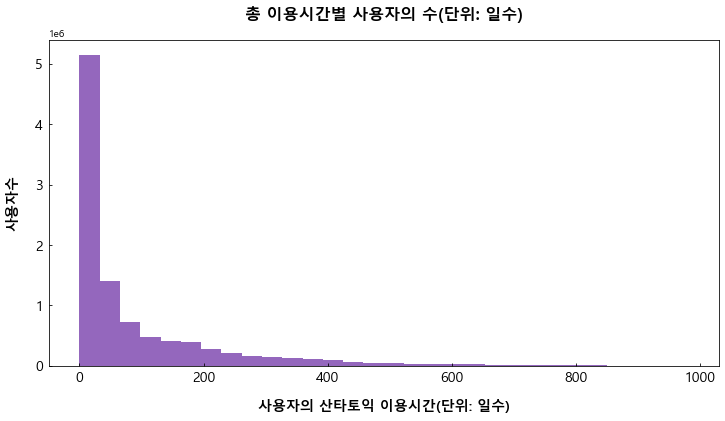

In [47]:
#1 year = 31536000000 ms
# 1s = 1000ms
# 1ms = 1/1000 s
# 60s = 1 min
# 60 min = 1 hr
# 1 day = 24hr
# 1 month = 30 * 24 * 60 * 60 * 1000 ms
# 1 year = 365 day = 365 * 24 hr 
# 1 year = 365 * 24 * 30 * 60 * 60 * 1000 ms
ts = train['timestamp']/(24 * 60 * 60 * 1000) # timestamp가 ms 단위인데 day로 환산

plt.figure(figsize=(12,6))
ts.plot.hist(bins=30, color='#9467bd')

# plt.title('cumulative days of users', pad=20)
plt.title('총 이용시간별 사용자의 수(단위: 일수)', fontdict=title_font, pad=20)
# plt.xlabel('Days between this user interaction and the first event completion from that user')
plt.xlabel('사용자의 산타토익 이용시간(단위: 일수)', labelpad=15, fontdict=font1)
plt.ylabel('사용자수', labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.show()

# 해야 될 것 : 각각 사용자의 일수를 가져오는 전처리 작업 필요 


In [48]:
train.user_id.nunique()

39491

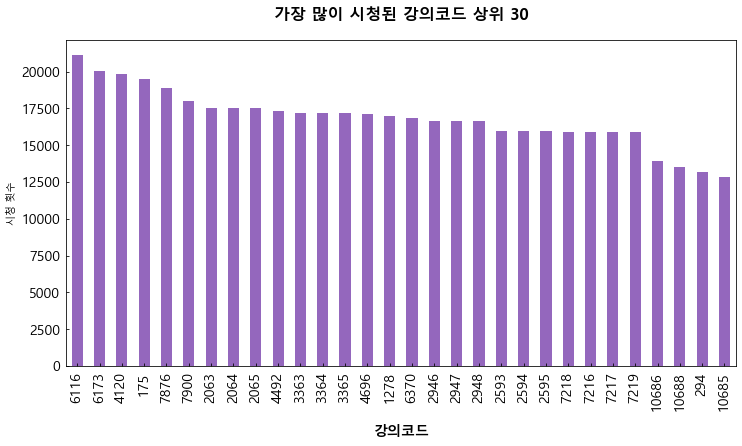

In [49]:
cids = train.content_id.value_counts()[:30]

plt.figure(figsize=(12,6))
cids.plot.bar(color='#9467bd')
# plt.title("Thirty most used content id's")
plt.title('가장 많이 시청된 강의코드 상위 30', fontdict=title_font, pad=20)
# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))s
plt.xlabel('강의코드', labelpad=15, fontdict=font1)
plt.ylabel('시청 횟수')
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)

plt.show()

In [50]:
train.content_type_id.value_counts()

0    9804604
1     195396
Name: content_type_id, dtype: int64

In [51]:
# user_answer = train.user_answer.value_counts()
# user_answer.plot.pie()
# # 수정 필요 (수치라던가, 제목이라던가)

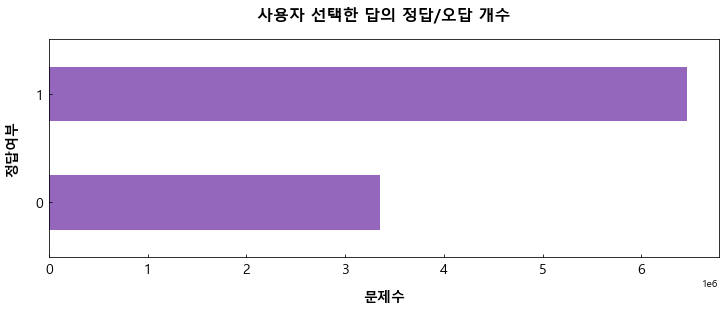

In [52]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

plt.figure(figsize=(12,4))
correct.plot.barh(color='#9467bd')
# for i, v in zip(correct.index, correct.values):
    # plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
# plt.title("Questions answered correctly")
plt.title('사용자 선택한 답의 정답/오답 개수', fontdict=title_font, pad=20)
plt.ylabel('정답여부', labelpad=15, fontdict=font1)
plt.xlabel('문제수', labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.show()

In [53]:
train[train.answered_correctly != -1].groupby('answered_correctly').size()
# train.pivot()

answered_correctly
0    3347179
1    6457425
dtype: int64

In [54]:
user_percent = train[train.answered_correctly != -1].groupby('user_id').answered_correctly.agg(Mean='mean', Answers='count')

In [55]:
user_percent[:15]

Mean  Answers
user_id                   
115      0.695652       46
124      0.233333       30
2746     0.578947       19
5382     0.672000      125
8623     0.642202      109
8701     0.588235       17
12741    0.573585      265
13134    0.706356     1243
24418    0.690275     6283
24600    0.340000       50
32421    0.466667       30
40828    0.630435       92
44331    0.587629      291
45001    0.233333       30
46886    0.613636       44

In [56]:
user_percent.Answers.max()

15562

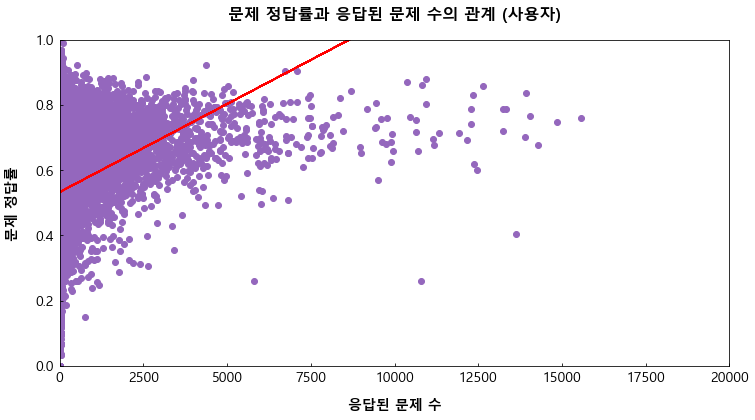

In [123]:
plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o', color='#9467bd')


plt.title('문제 정답률과 응답된 문제 수의 관계 (사용자)', fontdict=title_font, pad=20)
plt.xlabel('응답된 문제 수', labelpad=15, fontdict=font1)
plt.ylabel('문제 정답률', labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)

plt.xlim(-1, 20000)
plt.ylim(0.,1.0)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

In [58]:
content_percent = train[train.answered_correctly != -1].groupby('content_id').answered_correctly.agg(Mean='mean', Answers='count')

In [59]:
pqet = train[train.answered_correctly != -1]
pqet = pqet[['prior_question_elapsed_time', 'answered_correctly']]
pqet = pqet.groupby('answered_correctly').agg({'answered_correctly': 'count', 'prior_question_elapsed_time': 'mean' })

pqet

answered_correctly  prior_question_elapsed_time
answered_correctly                                                 
0                              3347179                 25704.232108
1                              6457425                 25357.034974

In [60]:
# 하나 푸는데 걸리는 평균 초
pqet.iloc[:,1] / 1000

answered_correctly
0    25.704232
1    25.357035
Name: prior_question_elapsed_time, dtype: float64

In [61]:
train.prior_question_had_explanation

0           <NA>
1          False
2          False
3          False
4          False
           ...  
9999995     True
9999996     True
9999997     True
9999998     True
9999999     True
Name: prior_question_had_explanation, Length: 10000000, dtype: boolean

In [62]:
# 여러개의 함수를 여러 열에 적용 : agg()함수
# 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
# 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})

pqhe =train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
pqhe

answered_correctly         
                                             mean    count
prior_question_had_explanation                            
False                                    0.500357   909661
True                                     0.674771  8855555
NaN                                      0.680309    39388

In [63]:
pqhe = pqhe.iloc[:,0]

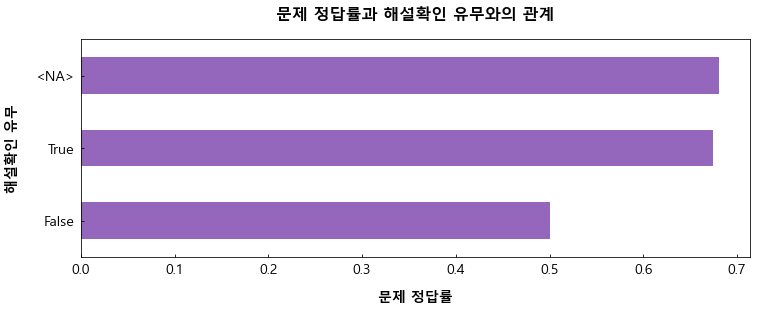

In [64]:
plt.figure(figsize=(12,4))
pqhe.plot.barh(color='#9467bd')
# plt.title("Answered_correctly versus Prior Question had explanation")
# plt.xlabel("Percent answered correctly")
# plt.ylabel("Prior question had explanation")

plt.title("문제 정답률과 해설확인 유무와의 관계", fontdict=title_font, pad=20)
plt.xlabel("문제 정답률", labelpad=15, fontdict=font1)
plt.ylabel("해설확인 유무", labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.show()

In [65]:
#tag당 문제 정답률을 나타내려고 작성한 코드
tags_df = pd.DataFrame()
for x in range(len(tags)): #
     df = questions[questions.tags.apply(lambda l: tags[x] in l)] # tags가 비슷한 행으로 묶음
     df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']}) #각열에 sum함수를 적용
     df1['Total_questions'] = df1.Wrong + df1.Right #Total_questions열 추가 값은 wrong,right를 합친 값 #총 문제의 수
     #df1['Question_ids_with_tag'] = len(df) #Question_ids_with_tag열 추가, 값은 len(df) //이거 왜쓰는지 모르겠음 안써도 될꺼같음
     df1['tag'] = tags[x] #tag 열 추가 값은 tag[x] : tags가 tag의 번치라면 tag는 낱개??
     df1 = df1.set_index('tag')
     tags_df = tags_df.append(df1)
df1
# tags_df.info() #삭제 예정
# tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int) # 타입 안바꿔도 될듯
# tags_df.info() #삭제 예정 
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions #'Percent_correct'열 추가 문제 맞춘 비율
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df
tags_df.fillna(0)  #결측치 제거 //결측치 지우지말고 0으로 fillna(0)
tags_df

Wrong  Right  Total_questions  Percent_correct
tag                                                
24   15523   9653            25176         0.383421
23   25673  20228            45901         0.440688
19   17267  13833            31100         0.444791
151  26954  25882            52836         0.489855
108  23213  23511            46724         0.503189
..     ...    ...              ...              ...
40    4134  18343            22477         0.816079
149   5939  33315            39254         0.848703
130   3605  20508            24113         0.850496
187   3470  21414            24884         0.860553
68    1583  10310            11893         0.866896

[188 rows x 4 columns]

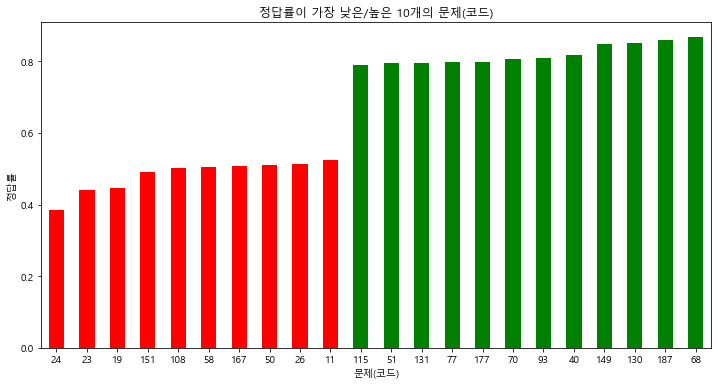

In [66]:
#어렵거나 쉬운 태그 top10
select_rows = list(range(0,10)) + list(range(176, len(tags_df))) # 0~9 + 176~188 마지막 결측치2개 포함
tags_select = tags_df.iloc[select_rows,3] 

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("정답률이 가장 낮은/높은 10개의 문제(코드)") # 어렵거나 쉬운 태그 top10 ##
plt.xlabel("문제(코드)") # 태그
plt.ylabel("정답률") # 태그별 문제 정답률
plt.xticks(rotation=0)
plt.show()

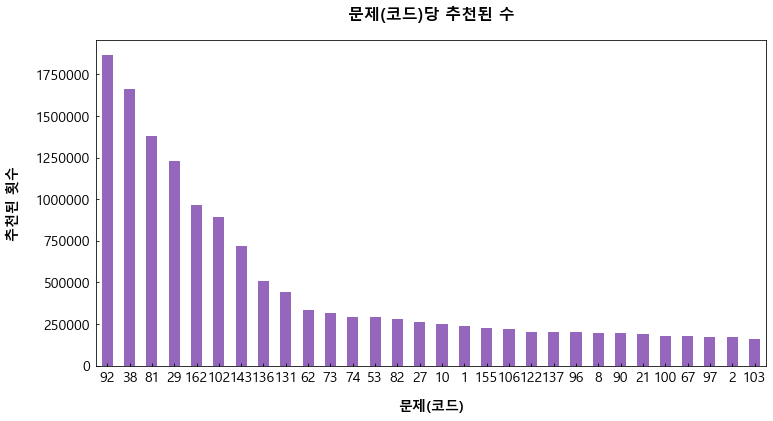

In [67]:
#태그당 사용된 횟수
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]
tags_select

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar(color='#9467bd')
plt.title("문제(코드)당 추천된 수", fontdict=title_font, pad=20) #태그당 사용된 횟수
plt.xlabel("문제(코드)", labelpad=15, fontdict=font1) # 태그 
plt.xticks(rotation=0) #90이 디폴트
plt.ylabel("추천된 횟수", labelpad=15, fontdict=font1)
plt.ticklabel_format(style='plain', axis='y')
#ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)

plt.show()

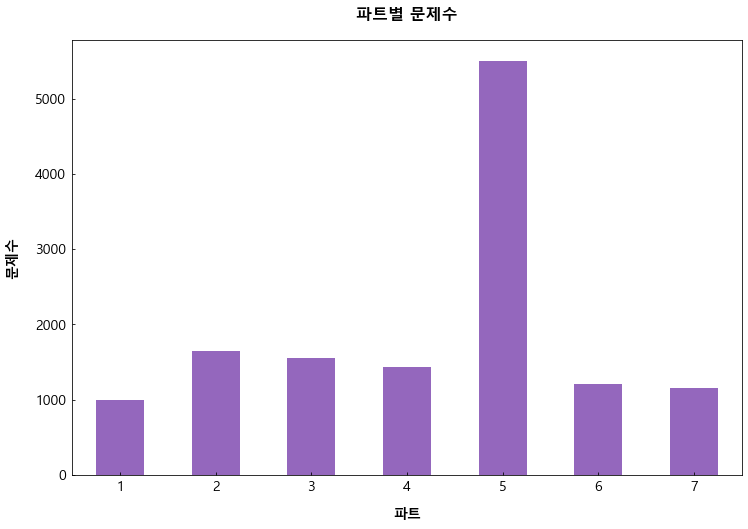

In [68]:
#파트별 문제수
plt.figure(figsize=(12,8))
questions.groupby('part').count()['question_id'].plot.bar(color='#9467bd')
plt.title("파트별 문제수", fontdict=title_font, pad=20) #파트별 문제수
plt.xlabel("파트", labelpad=15, fontdict=font1) #파트
plt.ylabel('문제수', labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.xticks(rotation=0)

plt.show()

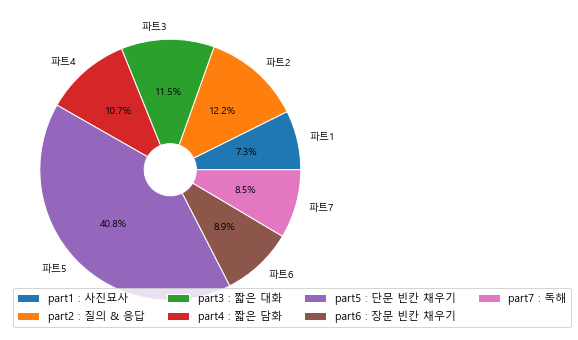

In [184]:
# 문제의 파트 비율
# (part1 : 사진묘사 / part2 : 질의 & 응답 / part3 : 짧은 대화 / part4 : 짧은 담화 / part5 : 단문 빈칸 채우기 / part6 : 장문 빈칸 채우기)


fig = plt.figure(figsize=(6,6))
labels = ['파트1','파트2','파트3','파트4','파트5', '파트6', '파트7'] #파트1~7
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 1}
ratio = questions.groupby("part").count()['question_id']
plt.pie(ratio, labels=labels, autopct='%.1f%%',wedgeprops=wedgeprops)
plt.legend(loc='lower left', fontsize=11, 
    ncol=4,
    labels=['part1 : 사진묘사', 'part2 : 질의 & 응답', 'part3 : 짧은 대화', 'part4 : 짧은 담화', 'part5 : 단문 빈칸 채우기', 'part6 : 장문 빈칸 채우기', 'part7 : 독해'])
plt.show()

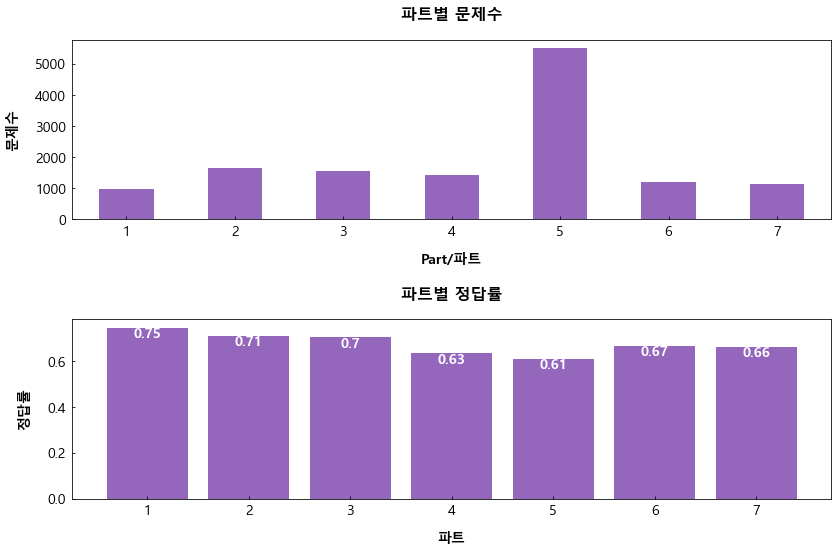

In [70]:
#파트별 문제수
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar(color='#9467bd')
plt.title("파트별 문제수", fontdict=title_font, pad=20) #파트별 문제수
plt.xlabel("Part/파트", labelpad=15, fontdict=font1) #파트
plt.xticks(rotation=0)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.ylabel('문제수', labelpad=15, fontdict=font1)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

#파트당 정답률
ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values, color='#9467bd')
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("파트별 정답률",  fontdict=title_font, pad=20) #파트당 정답률
plt.xlabel("파트", labelpad=15, fontdict=font1) #파트
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.ylabel('정답률', labelpad=15, fontdict=font1)

plt.show()

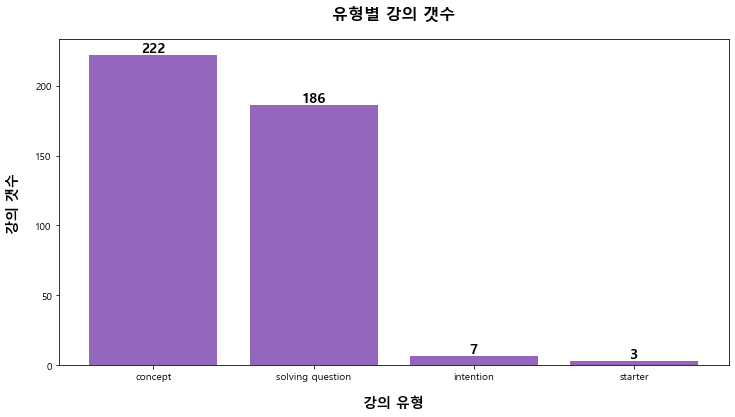

In [71]:
#강의 종류와 갯수 확인 (concept:222  solving question:86  intention:7  starter:3 )

lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values, color='#9467bd')
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("유형별 강의 갯수", fontdict=title_font, pad=20) #강의 종류와 강의 갯수
plt.xlabel("강의 유형", labelpad=15, fontdict=font1) #종류
plt.ylabel("강의 갯수", labelpad=15, fontdict=font1)
plt.xticks(rotation=0)

plt.show()

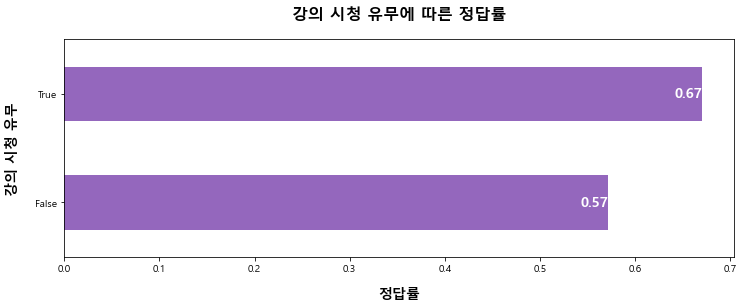

In [72]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
#print(user_lect) # answered_correctly (-1, 0, 1)이 칼럼이 됨

user_lect.columns = ['Lecture', 'Wrong', 'Right'] #칼럼명 지정
user_lect['Lecture'] = user_lect['Lecture'].fillna(0) #-1값이 없는 사람(강의를 한번도 안들은 사람)은 값이 NaN이므로 0으로 채워줌
user_lect = user_lect.astype('Int64') #float -> int
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False) # user_lect.Lecture:강의를 들은 횟수 나타냄
                                        #user_lect.Lecture가 0보다 크면(강의를 1회 이상 들었으면) True, 아니면 False
                                #np.where(조건, 조건이 참일때 입력되는 값, 거짓일때 입력되는값)
#print(user_lect.Lecture)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']}) #틀린문제, 맞은문제 sum
#print(watches_l)

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
                            #강의안들은사람, 들은사람 각각 맞은문제/전체문제 (맞은문제의비율) 구해서 새로운 칼럼(Percent_correct)으로 추가
#print(watches_l['Percent_correct']) #False:0.572016   True:0.670602

watches_l = watches_l.iloc[:,2] #watches_l의 칼럼 Wrong, Right, Percent_correct 중에 Percent_correct 만 가져옴

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh(color='#9467bd')
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("강의 시청 유무에 따른 정답률", fontdict=title_font, pad=20) # 강의 시청 유무에 따른 정답률
plt.xlabel("정답률", labelpad=15, fontdict=font1) #정답률
plt.ylabel("강의 시청 유무", labelpad=15, fontdict=font1) # 강의 시청 유무
plt.xticks(rotation=0)
plt.show()

In [73]:
train_lec = train[train.content_type_id == 1]
TrLe=pd.merge(train_lec, lectures, left_on='content_id', right_on='lecture_id')

TrLe=TrLe[['timestamp','user_id','content_id','task_container_id','lecture_id','tag','part','type_of']]

In [74]:
train_que = train[train.content_type_id == 0]
TrQu=pd.merge(train_que, questions, left_on='content_id', right_on='question_id')
TrQu[['timestamp','user_id','content_id','task_container_id','user_answer','answered_correctly','prior_question_elapsed_time','prior_question_had_explanation','question_id','bundle_id','correct_answer','part','tags']]

timestamp    user_id  content_id  task_container_id  user_answer  \
0                 0        115        5692                  1            3   
1        4216576228      24418        5692                497            3   
2                 0      51285        5692                  0            3   
3         330907575      91216        5692                153            3   
4         560202977     138650        5692                122            3   
...             ...        ...         ...                ...          ...   
9804599    89614441  160905333        7568                 90            0   
9804600  1718197416  184129602        4662               1511            1   
9804601   895221724  209508343        7848                606            1   
9804602   895221724  209508343        7850                606            2   
9804603   895221724  209508343        7849                606            2   

         answered_correctly  prior_question_elapsed_time  \
0                         1                          NaN   
1                         1                      21000.0   
2                         1                          NaN   
3                         1                      22000.0   
4                         1                      18000.0   
...                     ...                          ...   
9804599                   1                      15000.0   
9804600                   1                      20000.0   
9804601                   0                      60000.0   
9804602                   1                      60000.0   
9804603                   0                      60000.0   

         prior_question_had_explanation  question_id  bundle_id  \
0                                  <NA>         5692       5692   
1                                  True         5692       5692   
2                                  <NA>         5692       5692   
3                                  True         5692       5692   
4                                  True         5692       5692   
...                                 ...          ...        ...   
9804599                            True         7568       7566   
9804600                            True         4662       4662   
9804601                            True         7848       7848   
9804602                            True         7850       7848   
9804603                            True         7849       7848   

         correct_answer  part           tags  
0                     3     5          [151]  
1                     3     5          [151]  
2                     3     5          [151]  
3                     3     5          [151]  
4                     3     5          [151]  
...                 ...   ...            ...  
9804599               0     7   [18, 16, 21]  
9804600               1     5           [79]  
9804601               2     7   [76, 42, 21]  
9804602               2     7  [145, 42, 21]  
9804603               0     7   [97, 42, 21]  

[9804604 rows x 13 columns]

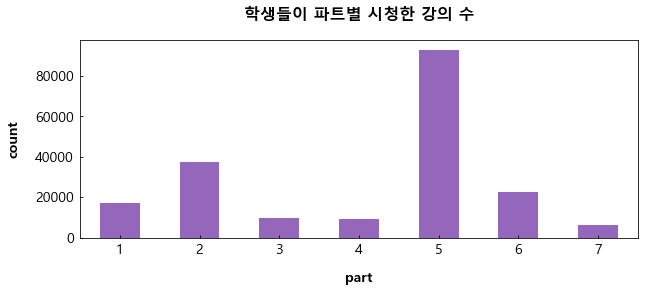

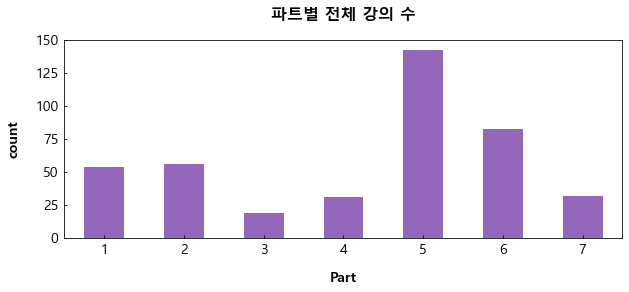

In [75]:
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(2,1,1)
ax1 = TrLe.groupby("part").count()['lecture_id'].plot.bar(color='#9467bd')
plt.title("학생들이 파트별 시청한 강의 수", fontdict=title_font, pad=20)
plt.xlabel("part", labelpad=15, fontdict=font1)
plt.ylabel("count", labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.xticks(rotation=0)

fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(2,1,1)
ax2 = lectures.groupby("part").count()['lecture_id'].plot.bar(color='#9467bd')
plt.title("파트별 전체 강의 수", fontdict=title_font, pad=20)
plt.xlabel("Part", labelpad=15, fontdict=font1)
plt.ylabel("count", labelpad=15, fontdict=font1)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.xticks(rotation=0)

plt.show()

In [76]:
TrLe

timestamp    user_id  content_id  task_container_id  lecture_id  \
0            653762       2746        6808                 14        6808   
1        1623661788      24418        6808                121        6808   
2         600004996      91216        6808                312        6808   
3        2461208170     138650        6808                182        6808   
4       10318788851     166728        6808                331        6808   
...             ...        ...         ...                ...         ...   
195391   8091107978  119665027       12509               3107       12509   
195392   3286282003  172724515       12509               5668       12509   
195393  10847836267  210490864       12509               3665       12509   
195394  11443860923   80655348       20852               3741       20852   
195395  27568190328  123466479       22353                578       22353   

        tag  part    type_of  
0       129     2  intention  
1       129     2  intention  
2       129     2  intention  
3       129     2  intention  
4       129     2  intention  
...     ...   ...        ...  
195391  145     7    concept  
195392  145     7    concept  
195393  145     7    concept  
195394  153     7    concept  
195395  156     6    concept  

[195396 rows x 8 columns]

In [77]:
tmp=pd.DataFrame(TrLe.groupby("task_container_id").user_id.count()) #
tmp=tmp.reset_index(drop=False)
tmp

task_container_id  user_id
0                     0        7
1                     1        1
2                     2        4
3                     3        3
4                     4        4
...                 ...      ...
5974               9990        1
5975               9993        1
5976               9994        1
5977               9996        1
5978               9998        1

[5979 rows x 2 columns]

In [78]:
bin_labels_20 = [int((len(TrLe)/20)*x) for x in range(1,21)]
tmp['ts_bin'] = pd.qcut(tmp['task_container_id'], q=20, labels=bin_labels_20)
tmp

task_container_id  user_id  ts_bin
0                     0        7    9769
1                     1        1    9769
2                     2        4    9769
3                     3        3    9769
4                     4        4    9769
...                 ...      ...     ...
5974               9990        1  195396
5975               9993        1  195396
5976               9994        1  195396
5977               9996        1  195396
5978               9998        1  195396

[5979 rows x 3 columns]

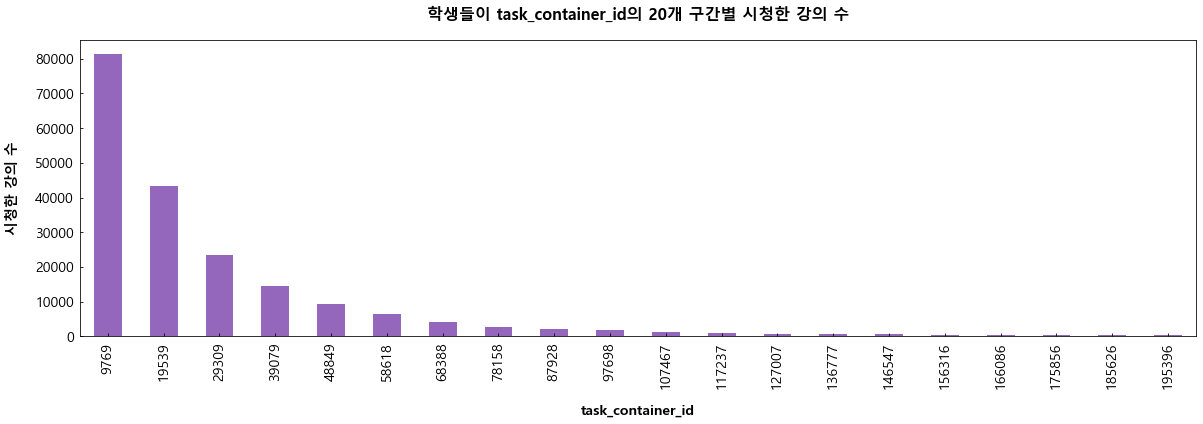

In [79]:
fig1=plt.figure(figsize=(20,12))
ax1 = fig1.add_subplot(2,1,1)
ax1 = tmp.groupby("ts_bin").sum()['user_id'].plot.bar(color='#9467bd')
plt.title("학생들이 task_container_id의 20개 구간별 시청한 강의 수", fontdict=title_font, pad=20)
plt.xlabel("task_container_id", labelpad=15, fontdict=font1)
plt.ylabel("시청한 강의 수", labelpad=15, fontdict=font1)
plt.xticks(rotation=90)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.show()

In [80]:
TrQu.user_id.nunique()

39491

In [81]:
tmp=pd.DataFrame(TrQu.groupby("user_id").task_container_id.max())
tmp=tmp.reset_index(drop=False)

In [82]:
tmp=pd.DataFrame(tmp.groupby("task_container_id").user_id.count())
tmp=tmp.reset_index(drop=False)
tmp[:20]

task_container_id  user_id
0                   0       13
1                   1        8
2                   2        3
3                   3       11
4                   4        3
5                   5        4
6                   6      571
7                   7       85
8                   8       82
9                   9       78
10                 10      130
11                 11      776
12                 12      415
13                 13      454
14                 14      314
15                 15     5948
16                 16     1892
17                 17      660
18                 18      587
19                 19      679

In [83]:
bin_labels_20 = [int(731/100*x) for x in range(1,101)]
tmp['ts_bin'] = pd.qcut(tmp['task_container_id'], q=100, labels=bin_labels_20)

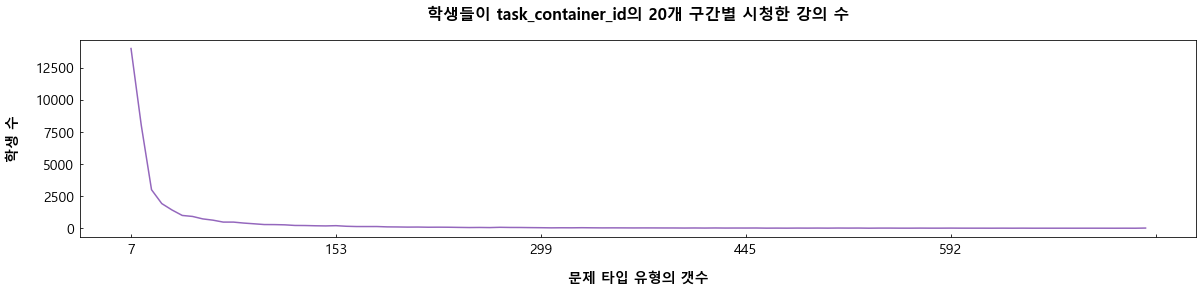

In [84]:
fig1=plt.figure(figsize=(20,8))
p = fig1.add_subplot(2,1,1)
p = tmp.groupby("ts_bin").user_id.sum().plot(color='#9467bd')

plt.title("학생들이 task_container_id의 20개 구간별 시청한 강의 수", fontdict=title_font, pad=20)
plt.xlabel("문제 타입 유형의 갯수", labelpad=15, fontdict=font1)
plt.ylabel("학생 수", labelpad=15, fontdict=font1)
plt.xticks(rotation=0)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.show()

---

### 모델 전처리

In [85]:
train

row_id  timestamp    user_id  content_id  content_type_id  \
0              0          0        115        5692                0   
1              1      56943        115        5716                0   
2              2     118363        115         128                0   
3              3     131167        115        7860                0   
4              4     137965        115        7922                0   
...          ...        ...        ...         ...              ...   
9999995  9999995  646228695  216747867        8805                0   
9999996  9999996  646321314  216747867        5708                0   
9999997  9999997  646393443  216747867        5434                0   
9999998  9999998  646445632  216747867        6429                0   
9999999  9999999  690225760  216747867        9010                0   

         task_container_id  user_answer  answered_correctly  \
0                        1            3                   1   
1                        2            2                   1   
2                        0            0                   1   
3                        3            0                   1   
4                        4            1                   1   
...                    ...          ...                 ...   
9999995                410            1                   1   
9999996                411            0                   0   
9999997                412            0                   0   
9999998                413            3                   1   
9999999                414            2                   1   

         prior_question_elapsed_time  prior_question_had_explanation  
0                                NaN                            <NA>  
1                            37000.0                           False  
2                            55000.0                           False  
3                            19000.0                           False  
4                            11000.0                           False  
...                              ...                             ...  
9999995                      23000.0                            True  
9999996                      13000.0                            True  
9999997                      66000.0                            True  
9999998                      37000.0                            True  
9999999                      16000.0                            True  

[10000000 rows x 10 columns]

In [86]:
train_que = train[train.content_type_id == 0]
train_lect = train[train.content_type_id == 1]
train_lect

row_id   timestamp    user_id  content_id  content_type_id  \
89            89      653762       2746        6808                1   
117          117    10183847       5382       16736                1   
212          212  1424348597       5382       30207                1   
216          216  1425557777       5382       18545                1   
295          295   405813029       8623       10540                1   
...          ...         ...        ...         ...              ...   
9999791  9999791   444772588  216747867        6761                1   
9999817  9999817   473000999  216747867       13336                1   
9999875  9999875   476351673  216747867       23855                1   
9999905  9999905   513697222  216747867       30681                1   
9999938  9999938   529899038  216747867       29559                1   

         task_container_id  user_answer  answered_correctly  \
89                      14           -1                  -1   
117                     21           -1                  -1   
212                    104           -1                  -1   
216                    121           -1                  -1   
295                     59           -1                  -1   
...                    ...          ...                 ...   
9999791                326           -1                  -1   
9999817                335           -1                  -1   
9999875                352           -1                  -1   
9999905                361           -1                  -1   
9999938                372           -1                  -1   

         prior_question_elapsed_time  prior_question_had_explanation  
89                               NaN                           False  
117                              NaN                           False  
212                              NaN                           False  
216                              NaN                           False  
295                              NaN                           False  
...                              ...                             ...  
9999791                          NaN                           False  
9999817                          NaN                           False  
9999875                          NaN                           False  
9999905                          NaN                           False  
9999938                          NaN                           False  

[195396 rows x 10 columns]

In [87]:
train_que = pd.merge(train_que, questions, left_on='content_id', right_on='question_id')
train_que

row_id   timestamp    user_id  content_id  content_type_id  \
0              0           0        115        5692                0   
1           2385  4216576228      24418        5692                0   
2           8954           0      51285        5692                0   
3           9280   330907575      91216        5692                0   
4          13269   560202977     138650        5692                0   
...          ...         ...        ...         ...              ...   
9804599  7414816    89614441  160905333        7568                0   
9804600  8484118  1718197416  184129602        4662                0   
9804601  9623046   895221724  209508343        7848                0   
9804602  9623047   895221724  209508343        7850                0   
9804603  9623048   895221724  209508343        7849                0   

         task_container_id  user_answer  answered_correctly  \
0                        1            3                   1   
1                      497            3                   1   
2                        0            3                   1   
3                      153            3                   1   
4                      122            3                   1   
...                    ...          ...                 ...   
9804599                 90            0                   1   
9804600               1511            1                   1   
9804601                606            1                   0   
9804602                606            2                   1   
9804603                606            2                   0   

         prior_question_elapsed_time  prior_question_had_explanation  \
0                                NaN                            <NA>   
1                            21000.0                            True   
2                                NaN                            <NA>   
3                            22000.0                            True   
4                            18000.0                            True   
...                              ...                             ...   
9804599                      15000.0                            True   
9804600                      20000.0                            True   
9804601                      60000.0                            True   
9804602                      60000.0                            True   
9804603                      60000.0                            True   

         question_id  bundle_id  correct_answer  part           tags  Wrong  \
0               5692       5692               3     5          [151]    917   
1               5692       5692               3     5          [151]    917   
2               5692       5692               3     5          [151]    917   
3               5692       5692               3     5          [151]    917   
4               5692       5692               3     5          [151]    917   
...              ...        ...             ...   ...            ...    ...   
9804599         7568       7566               0     7   [18, 16, 21]      0   
9804600         4662       4662               1     5           [79]      0   
9804601         7848       7848               2     7   [76, 42, 21]      1   
9804602         7850       7848               2     7  [145, 42, 21]      0   
9804603         7849       7848               0     7   [97, 42, 21]      1   

         Right  
0         2631  
1         2631  
2         2631  
3         2631  
4         2631  
...        ...  
9804599      1  
9804600      1  
9804601      0  
9804602      1  
9804603      0  

[9804604 rows x 17 columns]

In [88]:
train_lect = pd.merge(train_lect, lectures, left_on='content_id', right_on='lecture_id')
train_lect

row_id    timestamp    user_id  content_id  content_type_id  \
0            89       653762       2746        6808                1   
1          2009   1623661788      24418        6808                1   
2          9508    600004996      91216        6808                1   
3         13330   2461208170     138650        6808                1   
4         17156  10318788851     166728        6808                1   
...         ...          ...        ...         ...              ...   
195391  5610616   8091107978  119665027       12509                1   
195392  7956917   3286282003  172724515       12509                1   
195393  9680702  10847836267  210490864       12509                1   
195394  3770593  11443860923   80655348       20852                1   
195395  5742980  27568190328  123466479       22353                1   

        task_container_id  user_answer  answered_correctly  \
0                      14           -1                  -1   
1                     121           -1                  -1   
2                     312           -1                  -1   
3                     182           -1                  -1   
4                     331           -1                  -1   
...                   ...          ...                 ...   
195391               3107           -1                  -1   
195392               5668           -1                  -1   
195393               3665           -1                  -1   
195394               3741           -1                  -1   
195395                578           -1                  -1   

        prior_question_elapsed_time  prior_question_had_explanation  \
0                               NaN                           False   
1                               NaN                           False   
2                               NaN                           False   
3                               NaN                           False   
4                               NaN                           False   
...                             ...                             ...   
195391                          NaN                           False   
195392                          NaN                           False   
195393                          NaN                           False   
195394                          NaN                           False   
195395                          NaN                           False   

        lecture_id  tag  part    type_of  
0             6808  129     2  intention  
1             6808  129     2  intention  
2             6808  129     2  intention  
3             6808  129     2  intention  
4             6808  129     2  intention  
...            ...  ...   ...        ...  
195391       12509  145     7    concept  
195392       12509  145     7    concept  
195393       12509  145     7    concept  
195394       20852  153     7    concept  
195395       22353  156     6    concept  

[195396 rows x 14 columns]

In [89]:
train1 = pd.concat([train_que, train_lect])
train1 = train1.drop(['question_id', 'lecture_id', 'bundle_id'], axis=1)

In [90]:
train1 = train1.sort_values(by=['row_id']).reset_index(drop=True)
# train1.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True, inplace=True)
train1

row_id  timestamp    user_id  content_id  content_type_id  \
0              0          0        115        5692                0   
1              1      56943        115        5716                0   
2              2     118363        115         128                0   
3              3     131167        115        7860                0   
4              4     137965        115        7922                0   
...          ...        ...        ...         ...              ...   
9999995  9999995  646228695  216747867        8805                0   
9999996  9999996  646321314  216747867        5708                0   
9999997  9999997  646393443  216747867        5434                0   
9999998  9999998  646445632  216747867        6429                0   
9999999  9999999  690225760  216747867        9010                0   

         task_container_id  user_answer  answered_correctly  \
0                        1            3                   1   
1                        2            2                   1   
2                        0            0                   1   
3                        3            0                   1   
4                        4            1                   1   
...                    ...          ...                 ...   
9999995                410            1                   1   
9999996                411            0                   0   
9999997                412            0                   0   
9999998                413            3                   1   
9999999                414            2                   1   

         prior_question_elapsed_time  prior_question_had_explanation  \
0                                NaN                            <NA>   
1                            37000.0                           False   
2                            55000.0                           False   
3                            19000.0                           False   
4                            11000.0                           False   
...                              ...                             ...   
9999995                      23000.0                            True   
9999996                      13000.0                            True   
9999997                      66000.0                            True   
9999998                      37000.0                            True   
9999999                      16000.0                            True   

         correct_answer  part            tags   Wrong   Right  tag type_of  
0                   3.0     5           [151]   917.0  2631.0  NaN     NaN  
1                   2.0     5           [168]   628.0  1748.0  NaN     NaN  
2                   0.0     1  [131, 149, 92]    50.0  1864.0  NaN     NaN  
3                   0.0     1  [131, 104, 81]    95.0  2042.0  NaN     NaN  
4                   1.0     1  [131, 149, 92]    89.0  1789.0  NaN     NaN  
...                 ...   ...             ...     ...     ...  ...     ...  
9999995             1.0     5           [170]   244.0   380.0  NaN     NaN  
9999996             2.0     5           [127]  2884.0  2403.0  NaN     NaN  
9999997             1.0     5           [125]   896.0   913.0  NaN     NaN  
9999998             3.0     5           [170]  1768.0  2087.0  NaN     NaN  
9999999             2.0     5           [147]    95.0   407.0  NaN     NaN  

[10000000 rows x 17 columns]

In [91]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  boolean
 10  correct_answer                  float64
 11  part                            int64  
 12  tags                            object 
 13  Wrong                           float64
 14  Right                           float64
 15  tag                             float64
 16  type_of                         object 
dtypes: boolean(1), float64(5),

In [92]:
# lecture_id는 content_type_id가 1일때 content_id의 외래키
lectures

lecture_id  tag  part           type_of
0            89  159     5           concept
1           100   70     1           concept
2           185   45     6           concept
3           192   79     5  solving question
4           317  156     5  solving question
..          ...  ...   ...               ...
413       32535    8     5  solving question
414       32570  113     3  solving question
415       32604   24     6           concept
416       32625  142     2           concept
417       32736   82     3           concept

[418 rows x 4 columns]

In [93]:
# question_id는 content_type_id가 0일때 content_id의 외래키
questions

question_id  bundle_id  correct_answer  part                 tags  \
0                0          0               0     1   [51, 131, 162, 38]   
1                1          1               1     1        [131, 36, 81]   
2                2          2               0     1  [131, 101, 162, 92]   
3                3          3               0     1  [131, 149, 162, 29]   
4                4          4               3     1    [131, 5, 162, 38]   
...            ...        ...             ...   ...                  ...   
13495        13518      13518               3     5                 [14]   
13496        13519      13519               3     5                  [8]   
13497        13520      13520               2     5                 [73]   
13498        13521      13521               0     5                [125]   
13499        13522      13522               3     5                 [55]   

       Wrong  Right  
0         63    628  
1         77    649  
2       1970   2531  
3        500   1776  
4       1173   1980  
...      ...    ...  
13495     18     68  
13496     36     50  
13497     26     56  
13498     19     68  
13499      9     77  

[13500 rows x 7 columns]

In [94]:
train1.correct_answer.unique()

array([ 3.,  2.,  0.,  1., nan])

In [95]:
train1.correct_answer.isna().sum()

195396

In [96]:
train1['correct_answer'] = train1['correct_answer'].replace(np.nan, -1)

In [97]:
train1.correct_answer.unique()

array([ 3.,  2.,  0.,  1., -1.])

In [98]:
train1.astype({
    'correct_answer':int
})

row_id  timestamp    user_id  content_id  content_type_id  \
0              0          0        115        5692                0   
1              1      56943        115        5716                0   
2              2     118363        115         128                0   
3              3     131167        115        7860                0   
4              4     137965        115        7922                0   
...          ...        ...        ...         ...              ...   
9999995  9999995  646228695  216747867        8805                0   
9999996  9999996  646321314  216747867        5708                0   
9999997  9999997  646393443  216747867        5434                0   
9999998  9999998  646445632  216747867        6429                0   
9999999  9999999  690225760  216747867        9010                0   

         task_container_id  user_answer  answered_correctly  \
0                        1            3                   1   
1                        2            2                   1   
2                        0            0                   1   
3                        3            0                   1   
4                        4            1                   1   
...                    ...          ...                 ...   
9999995                410            1                   1   
9999996                411            0                   0   
9999997                412            0                   0   
9999998                413            3                   1   
9999999                414            2                   1   

         prior_question_elapsed_time  prior_question_had_explanation  \
0                                NaN                            <NA>   
1                            37000.0                           False   
2                            55000.0                           False   
3                            19000.0                           False   
4                            11000.0                           False   
...                              ...                             ...   
9999995                      23000.0                            True   
9999996                      13000.0                            True   
9999997                      66000.0                            True   
9999998                      37000.0                            True   
9999999                      16000.0                            True   

         correct_answer  part            tags   Wrong   Right  tag type_of  
0                     3     5           [151]   917.0  2631.0  NaN     NaN  
1                     2     5           [168]   628.0  1748.0  NaN     NaN  
2                     0     1  [131, 149, 92]    50.0  1864.0  NaN     NaN  
3                     0     1  [131, 104, 81]    95.0  2042.0  NaN     NaN  
4                     1     1  [131, 149, 92]    89.0  1789.0  NaN     NaN  
...                 ...   ...             ...     ...     ...  ...     ...  
9999995               1     5           [170]   244.0   380.0  NaN     NaN  
9999996               2     5           [127]  2884.0  2403.0  NaN     NaN  
9999997               1     5           [125]   896.0   913.0  NaN     NaN  
9999998               3     5           [170]  1768.0  2087.0  NaN     NaN  
9999999               2     5           [147]    95.0   407.0  NaN     NaN  

[10000000 rows x 17 columns]

In [99]:
train1[train.answered_correctly != -1].groupby(['content_type_id', 'user_id']).answered_correctly.mean()

content_type_id  user_id  
0                115          0.695652
                 124          0.233333
                 2746         0.578947
                 5382         0.672000
                 8623         0.642202
                                ...   
                 216740611    0.685714
                 216741934    0.788462
                 216743480    0.294118
                 216747710    0.480000
                 216747867    0.744071
Name: answered_correctly, Length: 39491, dtype: float64

In [100]:
# train1.to_csv('train1.csv')

---

### 상관 분석

<AxesSubplot:>

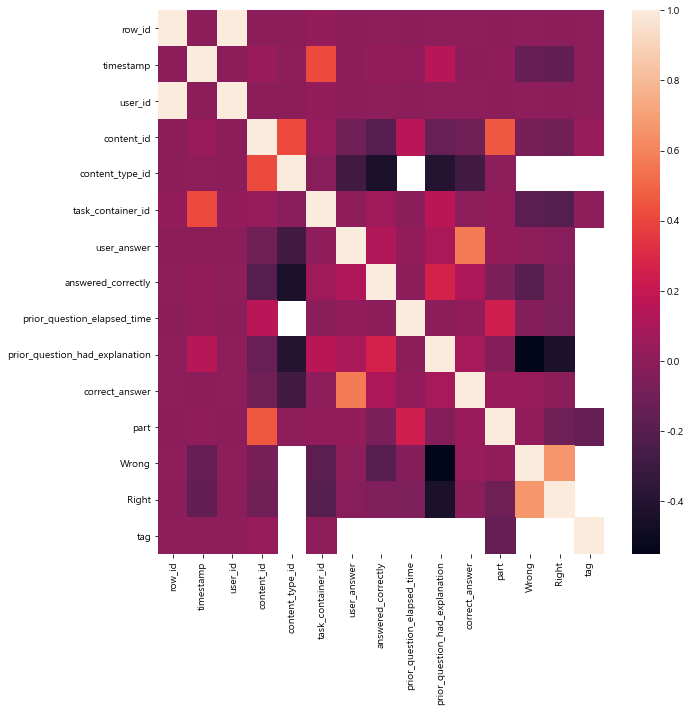

In [101]:
plt.figure(figsize=(10,10))
sns.heatmap(train1.corr()) # correlation

<AxesSubplot:>

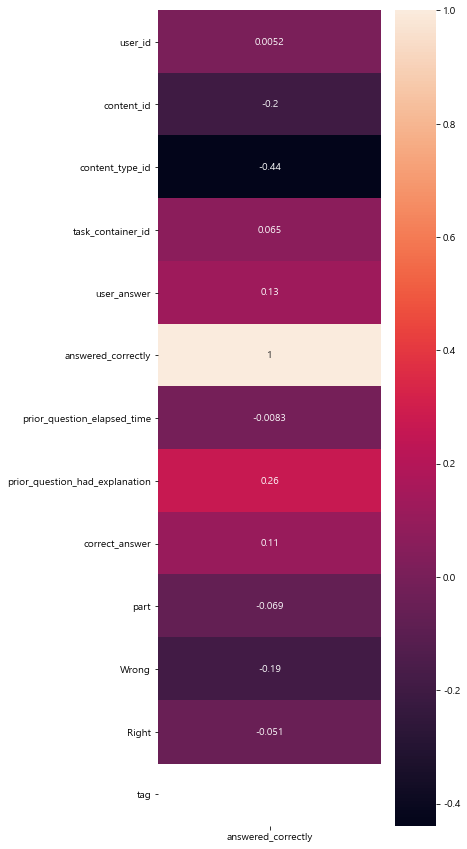

In [102]:
fig = plt.figure(figsize=(5,15))
sns.heatmap(train1.drop(['row_id', 'timestamp'], axis=1).corr()[['answered_correctly']], annot=True)

<AxesSubplot:>

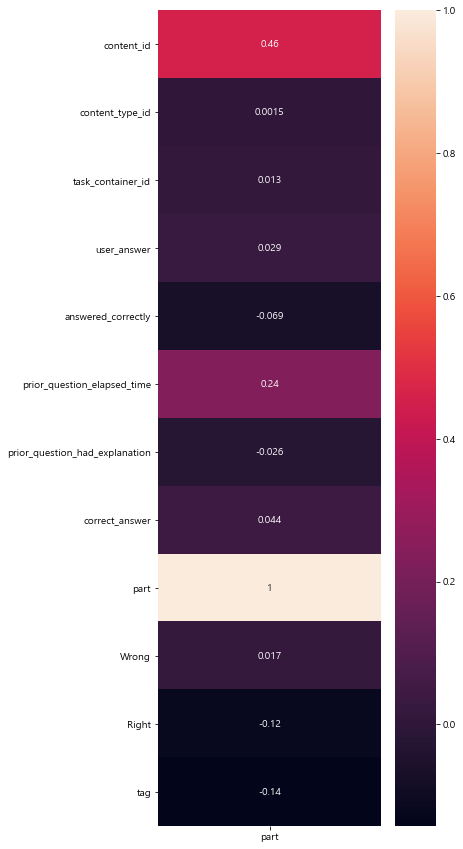

In [125]:
fig = plt.figure(figsize=(5,15))
sns.heatmap(train1.drop(['row_id', 'user_id', 'timestamp'], axis=1).corr()[['part']], annot=True)

---

## 데이터 모델 검증

In [104]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  boolean
 10  correct_answer                  float64
 11  part                            int64  
 12  tags                            object 
 13  Wrong                           float64
 14  Right                           float64
 15  tag                             float64
 16  type_of                         object 
dtypes: boolean(1), float64(5),

In [105]:
train1.prior_question_elapsed_time.fillna(0, inplace=True)
train1.prior_question_had_explanation.fillna(False, inplace=True)

In [106]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  boolean
 10  correct_answer                  float64
 11  part                            int64  
 12  tags                            object 
 13  Wrong                           float64
 14  Right                           float64
 15  tag                             float64
 16  type_of                         object 
dtypes: boolean(1), float64(5),

In [132]:
from sklearn.preprocessing import StandardScaler

In [133]:
train1.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'correct_answer', 'part', 'tags', 'Wrong', 'Right', 'tag', 'type_of'],
      dtype='object')

In [134]:
X_num = train1[['user_id', 'content_id', 'content_type_id',
        'task_container_id', 'user_answer', 'prior_question_elapsed_time',
        ]]
X_cat = train1[['part','prior_question_had_explanation']]

scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
y = train1['answered_correctly']

In [135]:
X

user_id  content_id  content_type_id  task_container_id  \
0       -1.711199    0.124746         -0.14117          -0.656936   
1       -1.711199    0.130951         -0.14117          -0.656186   
2       -1.711199   -1.313804         -0.14117          -0.657685   
3       -1.711199    0.685274         -0.14117          -0.655437   
4       -1.711199    0.701304         -0.14117          -0.654688   
...           ...         ...              ...                ...   
9999995  1.723232    0.929600         -0.14117          -0.350432   
9999996  1.723232    0.128883         -0.14117          -0.349683   
9999997  1.723232    0.058041         -0.14117          -0.348934   
9999998  1.723232    0.315294         -0.14117          -0.348184   
9999999  1.723232    0.982602         -0.14117          -0.347435   

         user_answer  prior_question_elapsed_time  part  \
0           1.360199                    -1.238389     5   
1           0.522400                     0.603454     5   
2          -1.153200                     1.499486     1   
3          -1.153200                    -0.292578     1   
4          -0.315400                    -0.690814     1   
...              ...                          ...   ...   
9999995    -0.315400                    -0.093460     5   
9999996    -1.153200                    -0.591255     5   
9999997    -1.153200                     2.047061     5   
9999998     1.360199                     0.603454     5   
9999999     0.522400                    -0.441916     5   

         prior_question_had_explanation  
0                                 False  
1                                 False  
2                                 False  
3                                 False  
4                                 False  
...                                 ...  
9999995                            True  
9999996                            True  
9999997                            True  
9999998                            True  
9999999                            True  

[10000000 rows x 8 columns]

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [139]:
from sklearn.linear_model import LogisticRegression  # 회귀선형식 => x,y 연속형 데이터 / 로지스틱 회귀선형식 => x,y 중에 범주형 데이터가 있을 때

In [140]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [141]:
from sklearn.metrics import classification_report

In [143]:
pred = model_lr.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     58635
           0       0.53      0.08      0.14   1003574
           1       0.67      0.96      0.79   1937791

    accuracy                           0.67   3000000
   macro avg       0.73      0.68      0.64   3000000
weighted avg       0.63      0.67      0.58   3000000



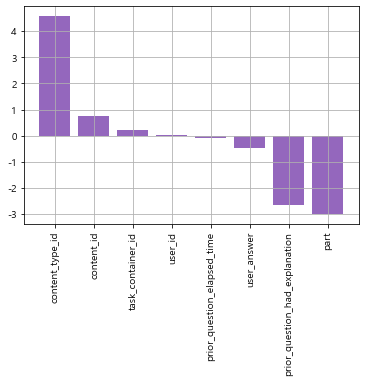

In [142]:
# Logistic Regression 모델의 coef_ 속성을 plot하기
model_coef = pd.DataFrame(data=model_lr.coef_[0], index=X.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.bar(model_coef.index, model_coef['Model Coefficient'], color='#9467bd')
plt.xticks(rotation=90)
plt.grid()
plt.show()
